In [132]:
# imports
import datetime as DT
from scipy import io
import numpy as np 
from matplotlib import pyplot as plt 
% matplotlib inline

In [133]:
fname = "/home/spike/Documents/USACE_Work/cmtb/SWASH/swashfiles/exampleOutput/agate2D_constantfriction/agate.mat"

# Define input/output Class 
This can hold both functions and data variables (and 2/3 + dimensional data) -- needs to be initalized to be used

In [210]:
class SWASHio: # actually write SWS file
    def __init__(self):
        self.WL = None
        self.equlibTime = None   # equilibration time in minutes for Tp to travel to shore and reflect back
        self.nLayers = 2
        self.Hs = None
        self.Tp = None
        self.Dm = None
        self.spreadD = None 
        
        
    def convertTimeDeltatoSWASHString(self, timeDeltaObj):
        hours = timeDeltaObj.total_seconds() // 3600
        minutes = (timeDeltaObj.total_seconds() % 3600) // 60
        seconds = (timeDeltaObj.total_seconds() % 60)
        return "{:02}{:02}{:02}.000".format(int(hours), int(minutes),int(seconds))
    
    def check_swsInput(self):
        assert self.WL is not None, "Need to set your waterLevel before writing file"
        assert self.equlibTime is not None, "Need to set equlibration Time before writing file"
        
    def write_sws(self, ofileNameBase, gridDict, nLayers=2):
        """ This function writes Regular Grid input file for the SWASH model
        This function pulls Water level from the initalized class

        Args:
            ofileNameBase(str): this function assumes all of the boundary, grid, files have the same name with
                a different file extension.  Convention is to use a datestring for the time of the model run
                (eg: YYYYmmhhTHHMMSSZ iso standard time, without ':'s )
            WLvalue (float): waterlevel value (model setup assumes NAVD88, but must be same datum as bot file)
            gridDict (dictionary): grid information
                keys here ... TBD

        Returns:
            None

        """
        self.check_swsInput()
        projectName = 'MetaDataString1==maybeVersionPrefix'
        metaField2 = 'OtherMetaData'
        dataReturnString = 'XP YP BOTL WATL VEL VELK USTAR NHPRSK VZ'
        # note: my string denotion is done with double so single quotes can be written into SWASH input file
        ##################### set variables for file write -- variable
        nx = gridDict['nx']     # number of mesh outputs 
        ny = gridDict['ny']     # number of mesh outputs 
        dx = gridDict['dx']     # mesh/grid resolution [m]
        dy = gridDict['dy']     # mesh/grid resolution [m]
        print("should the grid Dictionary be nx,ny, dx,dy or something else?")
        if nLayers > 6:
            warnings.warn('Check Friction, Breaking, and Numerics@@@@!!! ')
        # file names for output and read
        grdFile = '{}.grd'.format(ofileNameBase)              # where are the grid data stored
        ofname = "{}.sws".format(ofileNameBase)               # what is the file we are writing out called
        botFname = '{}.bot'.format(ofileNameBase)             # where do the bathy elevations go
        offshoreBoundaryFile = '{}.bnd'.format(ofileNameBase) # what's the name of the offshore boundary 
        outputMatFile = '{}.mat'.format(ofileNameBase)        # what's model results file name

        # calculate equlib time based on conditions 

        ########################## set variables for file write -- static
        modelStationarity= "NONSTationary"
        ModelMode = "TWODimensional"
        gridType = 'REGular'
        assert gridType in ["REGular", "CURVilinear"], "Check Grid type" # list of grid Types available
        ##########################
        # settings  for reading grd file  -- these might change with FRF coordinate system
        ## see page 40/41 - chapter 4 of SWAN manual for  more information (SWASH and SWAN are similar)
        grdFac =  1  # multiplaction factor for all values read from file (eg 1, -1, or 0.1 for decimeter conversion to [m]) 
        idla = 1  # prescribes the order in which the values of bottom levels and other fields should be given in file [1, 2, 3, 4 or 5]
        nhedf = 0 # number of header lines at start of file
        nhedvec = 0 # number of header lines in the file at the start of each componant
        fortranFormat = 'FREE'  # fortran format [FREE or FORMAT]
        ##########################
        # regular grid Settings 
        gridType = 'REGULAR' 
        xpc = 36.1776    # latitude origin local grid in global grid  -- frf 
        ypc = 75.7497    # longitude origin local grid in global grid
        alpc = 18.2      # degrees counter clockwise rotation from true North 
        xlenc = dx * nx  # length of the computational grid in x -direction (in m).
        ylenc = dy * ny  # length of the computational grid in y -direction (in m)
        mxc = nx - 1     # number of meshes in computational grid in x -direction for a uniform
        myc = ny - 1     # number of meshes in computational grid in y -direction for a uniform
        ###########################
        # bathymetry settings 
        bottomFac = -1  # multiplaction factor for all values read from file (eg 1, -1, or 0.1 for decimeter conversion to [m])
        ###########################
        # physical parameters settings
        backVisc = 1.e-4 # the background viscosity (in m2/s). Experiences suggest a value of 10-4 to 10-3 m2/s. Default: [backvisc] = 0.
        alphaBreaking = 0.6 # threshold parameter at which to initiate wave breaking
        betaBreaking = 0.3  # threshold parameter at which to stop wave breaking.
        dissipationBreaking = 0.25  # (default = 1) This value was used in Pieter's paper 2014 CE 
        turbModel = "KEPS"
        manningsN = 0.019
        ### model output and compute request stuff
        outputLocationOnshore = 2        # both the same its take the middle (1, 2, 3) value in alongshore and orient
        outputLocationOffshore = 2       # with cross-shore orientation. 
        startTime = 0.0                                                             # start time in seconds 
        sampleRate = 0.5                                                            # sample rate in seconds 
        RunTime = 2048                                                              # length of simulated time (or collection) in [seconds]
        endTime = DT.timedelta(seconds=startTime + RunTime + self.equlibTime*60)    # end time calculated in seconds 
        equlibStr = self.convertTimeDeltatoSWASHString(DT.timedelta(minutes=self.equlibTime)) 
        endTimeStr = self.convertTimeDeltatoSWASHString(endTime)
        timestep = 0.001                                                            # default time step 
        ###################### write file now ################################################
        nowString = DT.datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")
        f = open(ofname, 'w')
        f.write("$*************HEADING***********************************\n$ Coastal Model Test Bed SWASH setup up.\n$\n$")
        f.write("$ file written at: {}\n".format(nowString))
        f.write("$ wave Hs = {}; wave Tp = {}s; wave Dm = {}; wave Dir Spread {}".format(self.Hs, self.Tp, self.Dm, self.spreadD))
        f.write("$ if the above are 'None', then the IO class wasn't properly initated")
        f.write("PROJ {} {}\n".format(projectName, metaField2))
        f.write("$\n$This file is automatically Generated as part of CMTB\n"+
                "$written by: Spicer Bak, with help from Julia Fieldler\n")
        f.write("$***********MODEL INPUT*********************************\n$\n")
        f.write("MODE {} {}\n".format(modelStationarity, ModelMode))
        f.write("$\n$\n$Grid Descriptors \n$\n")
        f.write('CGRID {} {} {}\n'.format(gridType, nx, ny))
        f.write("$\n$\n$\n$Grid coordinates file\n$\n")
        f.write("READinp COORdinates {} {} {} {} {} {}\n$\n".format(grdFac, grdFile, idla, nhedf, nhedvec, fortranFormat)) 
        f.write("$\nINPGRID BOTTOM {} {} {} {} {} {} {}\n$\n".format(gridType, xpc, ypc, alpc, xlenc, ylenc, mxc, myc))
        f.write("$\n$Vertical Layers\n$\n")
        f.write("VERT {}\n".format(nLayers))
        f.write("$\n$\n$Bathymetry values (*.bot file)\n$\n")
        f.write("READINP BOTTOM {} {} {} {} {}\n".format(bottomFac, botFname, idla, nhedf, fortranFormat))
        f.write("$\n$\n$Set Water Level values\n$\n")
        f.write("SET level = {}\n".format(self.WL))
        f.write("$\n$\n$Set Friction, Viscosity, Breaker, etc\n$\n")
        f.write("FRIC MANN {}\n".format(manningsN))
        f.write("SET BACKVISC {}\n".format(backVisc))
        f.write("BREAK {} {} {}\n".format(alphaBreaking, betaBreaking, dissipationBreaking))
        f.write("VISC VERT {}\n".format(turbModel))
        f.write("INCLUDE {}\n".format(offshoreBoundaryFile))
        ##### NUMERICS -- HARD CODED! #####
        f.write("$\n$Set Numerics (these are hardcoded for now)\n$\n")
        f.write("$\nNONHYDROSTATIC BOX 1 PRECONDITIONER ILU\nDISCRET CORRDEP MUSCL\n")
        f.write("DISCRET UPW UMOM MOM VERT FIR\nDISCRET UPW UMOM MOM HOR MUSCL\nTIMEI 0.05 0.2\n")        
        f.write("$***********MODEL OUTPUT REQUESTS*********************************\n$\n")
        f.write("GROUP 'LINE' 1 {} {} {}\n".format(1, nx, outputLocationOnshore, outputLocationOffshore))
        # define which output we want
        f.write("BLOCK 'LINE' NOHEAD '{}' LAY 1 {} OUTPUT  {} {} SEC\n".format(outputMatFile, dataReturnString, equlibStr, sampleRate))
        f.write("TEST 1 0\n")  # write out time series to print file (aka log file)     
        f.write("COMPUTE {:.2f} {:.3f} SEC {}\nSTOP".format(startTime, timestep, endTimeStr)) 
        f.close()
    
    ### Now Read functions 
    
    def loadSwashMat(self, fname):
        """This function will load the model output file, it will pull the input water level from the 
        preinitalized instance

        Args:
            fname (str): the input file name to load

        Returns:
            Data dictionary with keys directly associated from matfile output

        """
        assert fname[:-3] == 'mat', 'expected output file is a matfile'
        import h5py
        f = h5py.File(fname)
        data = {}
        with h5py.File(fname, 'r') as f:
            for varOut, dataValues in f.items():
                data[varOut] = np.squeeze(dataValues)
        #         print(" {} var is shaped {}".format(varOut, np.shape(data[varOut])))
        data['WL'] = self.WL
        print('These output values should be renamed to CMTB conventions')
        return data


# Test input Write Functionality
Here we'll generate model input files to have something to test 


In [211]:
### define function inputs for SWS file 
swio = SWASHio()
swio.equlibTime =  5   # equilibration time in minutes for Tp to travel to shore and reflect back
swio.WL = 0.5 # [m]
gridDict= {'nx': 801, 'ny': 2, 'dx': 1, 'dy': 1}
ofileNameBase = "20121012T230000Z"
swio.write_sws(ofileNameBase, gridDict, nLayers=2)

should the grid Dictionary be nx,ny, dx,dy or something else?


## now read output functions


In [183]:
def plotTestData(data):
    for key in data:
        plt.figure()
        print(key)
        if key not in ['isProcessed', 'time']:
            try:
#                 print(key)
                plt.title(key)
                plt.pcolormesh(data['time'], data['Xp'], data[key][:,:].squeeze().T)
                plt.colorbar()
            except(IndexError):
                plt.plot(data['Xp'], data[key], '.')

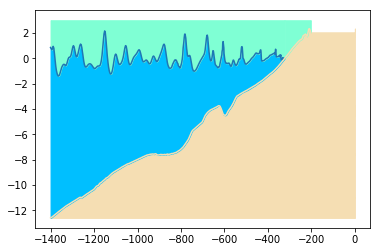

In [268]:
# first plot single water level and 
ofname = 'GifPlotSwash'
dataIn = data['Watlev']
bottomIn = -data['Botlev']
xIn = data['Xp']
time = data['time']

tt=0
plt.figure()
ax1 = plt.subplot(111)
ax1.plot(xIn, dataIn[tt])
ax1.plot(xIn, bottomIn, color='wheat')
ax1.fill_betweenx(bottomIn, xIn, color='wheat')
ax1.fill_between(xIn, bottomIn, dataIn[tt], color='deepskyblue')
ax1.fill_between(xIn, dataIn[tt], 3, color='aquamarine')
ax1.fill_between(xIn, bottomIn, 3, where=np.isnan(dataIn[tt]), color='aquamarine')
# also try setting background color with ax1.set_facecolor('aquamarine')

# plt.savefig(ofname+'.png')

In [266]:
print(np.isnan(dataIn[tt]).shape)
print(xIn.shape)

(700,)
(700,)


In [261]:
help(plt.fill_between)

Help on function fill_between in module matplotlib.pyplot:

fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, hold=None, data=None, **kwargs)
    Fill the area between two horizontal curves.
    
    The curves are defined by the points (*x*, *y1*) and (*x*, *y2*). This
    creates one or multiple polygons describing the filled area.
    
    You may exclude some horizontal sections from filling using *where*.
    
    By default, the edges connect the given points directly. Use *step* if
    the filling should be a step function, i.e. constant in between *x*.
    
    
    Parameters
    ----------
    x : array (length N)
        The x coordinates of the nodes defining the curves.
    
    y1 : array (length N) or scalar
        The y coordinates of the nodes defining the first curve.
    
    y2 : array (length N) or scalar, optional, default: 0
        The y coordinates of the nodes defining the second curve.
    
    where : array of bool (length N), optional, de

Botlev
Botlev
Veta
Veta
Vksi
Vksi
Watlev
Watlev
Xp
Xp
isProcessed
time
vel_x
vel_x
vel_y
vel_y


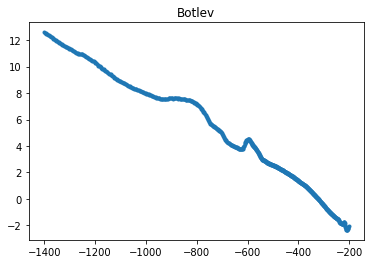

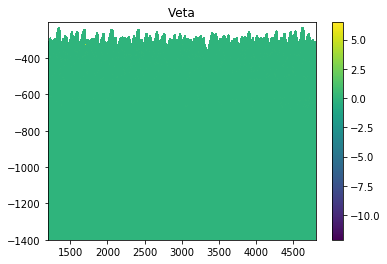

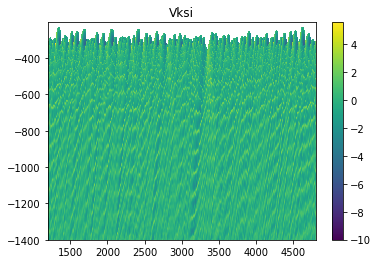

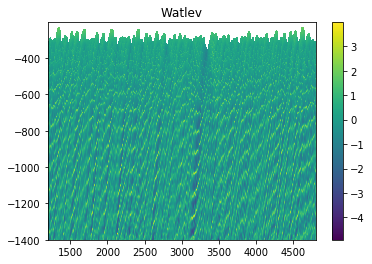

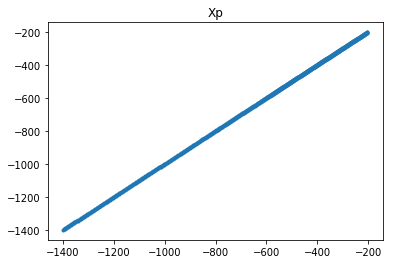

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

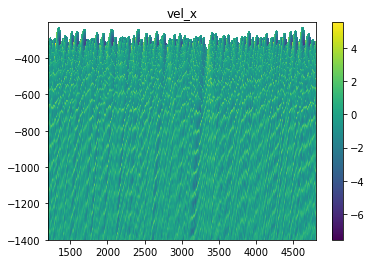

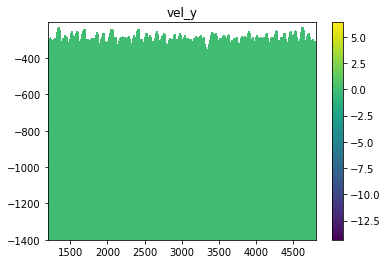

In [184]:
plotTestData(data)